# Data Mapping Verification and Visualization

This notebook verifies the integrity of the preprocessed data by ensuring that each image correctly maps to its corresponding transcription. Additionally, it visualizes sample data to provide a qualitative assessment of the preprocessing pipeline.

In [1]:
# Import essential libraries
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image

Loading pre-processed data

In [2]:
# Define file paths
preprocessed_images_path = 'preprocessed_images.npy'
encoded_transcriptions_path = 'encoded_transcriptions.json'
mappings_path = 'mappings.json'

# Load preprocessed images
print("Loading preprocessed images...")
preprocessed_images = np.load(preprocessed_images_path)
print(f"Preprocessed images shape: {preprocessed_images.shape}")  # Expected: (num_images, height, width, 1)

# Load encoded transcriptions
print("Loading encoded transcriptions...")
with open(encoded_transcriptions_path, 'r', encoding='utf-8') as f:
    encoded_transcriptions = json.load(f)
print(f"Number of encoded transcriptions: {len(encoded_transcriptions)}")

# Load mappings
print("Loading mappings...")
with open(mappings_path, 'r', encoding='utf-8') as f:
    mappings = json.load(f)

char_to_idx = mappings['char_to_idx']
idx_to_char = {int(k): v for k, v in mappings['idx_to_char'].items()}  # Ensure keys are integers
max_width = mappings['max_width']
fixed_height = mappings['fixed_height']

print(f"Vocabulary size: {len(char_to_idx)}")
print(f"Max width: {max_width}px")
print(f"Fixed height: {fixed_height}px")

Loading preprocessed images...
Preprocessed images shape: (13353, 128, 4096, 1)
Loading encoded transcriptions...
Number of encoded transcriptions: 13353
Loading mappings...
Vocabulary size: 82
Max width: 4096px
Fixed height: 128px


### Basic Validations

In [3]:
# Verify that the number of images matches the number of transcriptions
num_images = preprocessed_images.shape[0]
num_transcriptions = len(encoded_transcriptions)

print(f"Number of images: {num_images}")
print(f"Number of transcriptions: {num_transcriptions}")

if num_images != num_transcriptions:
    print("Mismatch detected: The number of images does not match the number of transcriptions.")
else:
    print("Validation Passed: The number of images matches the number of transcriptions.")

Number of images: 13353
Number of transcriptions: 13353
Validation Passed: The number of images matches the number of transcriptions.


#### Visualising the sample Data

In [4]:
# Function to decode encoded transcription
def decode_transcription(encoded_seq, idx_to_char_mapping):
    """
    Decode a list of integer indices back to a string transcription.

    Args:
        encoded_seq (List[int]): Encoded transcription.
        idx_to_char_mapping (Dict[int, str]): Mapping from index to character.

    Returns:
        str: Decoded transcription.
    """
    return ''.join([idx_to_char_mapping.get(idx, '<UNK>') for idx in encoded_seq])

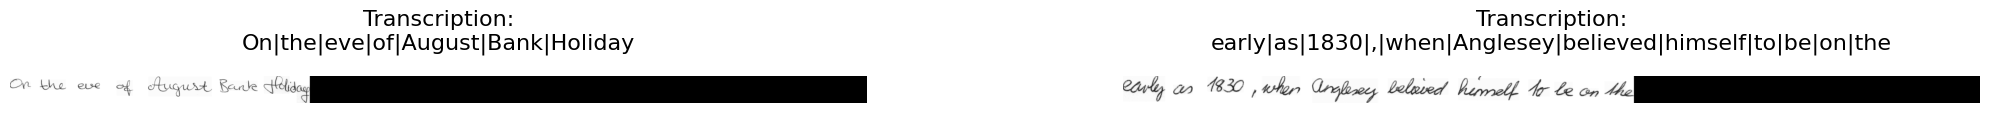

In [5]:
# Number of samples to visualize
num_samples = 2

# Randomly select sample indices
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(num_images, num_samples, replace=False)

# Determine layout based on number of samples
if num_samples == 1:
    fig, axes = plt.subplots(1, 1, figsize=(10, 8))
    axes = [axes]  # Make it iterable
else:
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 8))  # Increase figure size for better readability

# Plot the samples
for ax, idx in zip(axes, sample_indices):
    image = preprocessed_images[idx].squeeze()  # Remove channel dimension
    transcription = decode_transcription(encoded_transcriptions[idx], idx_to_char)
    
    # Convert image to uint8 for better visualization if necessary
    if image.max() <= 1.0:
        image_display = (image * 255).astype(np.uint8)
    else:
        image_display = image.astype(np.uint8)
    
    # Display the image
    ax.imshow(image_display, cmap='gray')
    
    # Set the title with increased font size and padding
    ax.set_title(f"Transcription:\n{transcription}", fontsize=16, pad=20)
    
    # Remove axis ticks
    ax.axis('off')

# Adjust layout for adequate spacing
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Increase horizontal and vertical spacing

# Display the plot
plt.show()

### Validate Encoding and Decoding

In [6]:
# Function to encode transcription using char_to_idx
def encode_transcription(text, char_to_idx_mapping):
    """
    Encode a string transcription into a list of integer indices.

    Args:
        text (str): Original transcription.
        char_to_idx_mapping (Dict[str, int]): Mapping from character to index.

    Returns:
        List[int]: Encoded transcription.
    """
    return [char_to_idx_mapping.get(char, char_to_idx_mapping['<UNK>']) for char in text]

# Select a sample to test encoding and decoding
test_idx = sample_indices[0]
test_encoded = encoded_transcriptions[test_idx]
test_decoded = decode_transcription(test_encoded, idx_to_char)

# For validation, re-encode the decoded transcription and compare with original encoding
re_encoded = encode_transcription(test_decoded, char_to_idx)

# Compare the two encodings
if test_encoded == re_encoded:
    print("Encoding and Decoding Validation Passed for the sample.")
else:
    print("Validation Failed: There is a mismatch in encoding and decoding.")
    print(f"Original Encoded: {test_encoded}")
    print(f"Re-Encoded:      {re_encoded}")

Encoding and Decoding Validation Passed for the sample.


### Vocabulary Consistency Check

In [7]:
# Display a subset of the vocabulary
print("Sample of the vocabulary (character to index mapping):")
for char, idx in list(char_to_idx.items())[:10]:
    print(f"'{char}': {idx}")

print("\nSample of the inverse vocabulary (index to character mapping):")
for idx, char in list(idx_to_char.items())[:10]:
    print(f"{idx}: '{char}'")

Sample of the vocabulary (character to index mapping):
'<PAD>': 0
'<UNK>': 1
' ': 2
'!': 3
'"': 4
'#': 5
'&': 6
''': 7
'(': 8
')': 9

Sample of the inverse vocabulary (index to character mapping):
0: '<PAD>'
1: '<UNK>'
2: ' '
3: '!'
4: '"'
5: '#'
6: '&'
7: '''
8: '('
9: ')'


### Dimension Check

Image Heights: min=128, max=128, mean=128.00
Image Widths: min=4096, max=4096, mean=4096.00


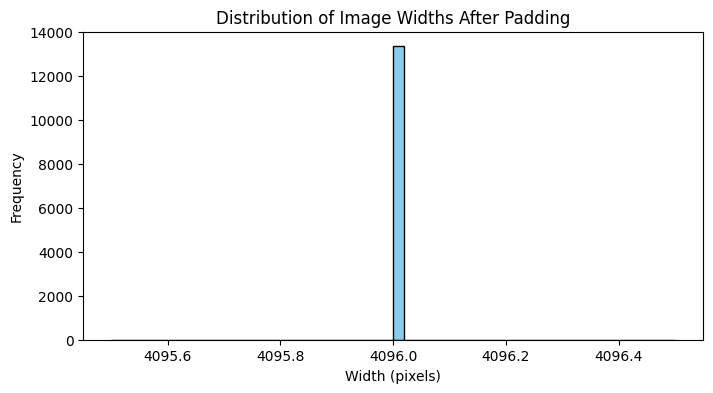

In [8]:
# Display some statistics about image dimensions
heights = []
widths = []

for image in preprocessed_images:
    heights.append(image.shape[0])
    widths.append(image.shape[1])

print(f"Image Heights: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.2f}")
print(f"Image Widths: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.2f}")

# Plot the distribution of image widths
plt.figure(figsize=(8, 4))
plt.hist(widths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Image Widths After Padding')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()
